In [61]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchmetrics.functional as metrics


from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.models import vgg11, vgg16, VGG11_Weights, VGG16_Weights
from sklearn.model_selection import train_test_split
from typing import List, Dict, Union


from torchinfo import summary


In [62]:
class Custom_VGG(nn.Module):
    def __init__(
        self,
        features: nn.Module,
        nclasses: int = 3,
        init_weights: bool = True,
        dropout: float = 0.5,
    ) -> None:
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2048),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(2048, 128),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(128, nclasses),
        )
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(
                        m.weight, mode="fan_out", nonlinearity="relu"
                    )
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [63]:
# fmt: off
cfgs: Dict[str, List[Union[str, int]]] = {
    "VGG6" : [64, "M", 128, "M", 256, "M", 512, "M"],
    "VGG7" : [64, "M", 128, "M", 256, "M", 512, "M", 512, "M"],
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "VGG19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}
# fmt: on


In [64]:
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = int(v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


In [65]:
def make_weights(labels: pd.DataFrame, nclasses: int):
    labels = labels.values
    weight_list = []

    for cls in range(nclasses):
        idx = np.where(labels == cls)[0]
        count = len(idx)
        weight = 1 / count
        weights = [weight] * count
        weight_list += weights

    return weight_list


In [68]:
def make_DataLoader(size: int = 256, batch_size: int = 64, view: bool = False):
    crop_size = 224 if size == 256 else 112
    preprocessing = transforms.Compose(
        [
            transforms.Resize(
                size, interpolation=transforms.InterpolationMode.BILINEAR
            ),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )

    file_root = "../DATA"
    dogDS = ImageFolder(root=file_root, transform=preprocessing)

    if view:
        print(dogDS.classes, len(dogDS.targets), len(dogDS.imgs), sep="\n")

    imgDF = pd.DataFrame(dogDS.imgs, columns=["image", "label"])
    imageDF = imgDF[["image"]]
    labelSR = imgDF.label

    X_train, X_valid, y_train, y_valid = train_test_split(
        imageDF, labelSR, test_size=0.1, random_state=42, stratify=labelSR
    )

    if view:
        print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, sep="\n")

    train_idx = X_train.index.to_list()
    valid_idx = X_valid.index.to_list()

    trainDS = Subset(dogDS, train_idx)
    validDS = Subset(dogDS, valid_idx)

    if view:
        print(len(trainDS.dataset.targets), len(validDS.dataset.targets))

    train_weights = make_weights(y_train, len(y_train.unique()))
    train_weights = torch.DoubleTensor(train_weights)
    valid_weights = make_weights(y_valid, len(y_valid.unique()))
    valid_weights = torch.DoubleTensor(valid_weights)

    train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
    valid_sampler = WeightedRandomSampler(valid_weights, len(valid_weights))

    trainDL = DataLoader(
        trainDS, batch_size=batch_size, sampler=train_sampler, drop_last=True
    )
    validDL = DataLoader(
        validDS, batch_size=batch_size, sampler=valid_sampler, drop_last=True
    )

    if view:
        for image, label in trainDL:
            print(image.shape, label.shape)
            pltsize = 1
            plt.figure(figsize=(10 * pltsize, pltsize))
            for i in range(10):
                plt.subplot(1, 10, i + 1)
                plt.axis("off")
                plt.imshow(np.transpose(image[i], (1, 2, 0)))
                plt.title("Class: " + str(label[i].item()))
            plt.show()
            break

    return trainDL, validDL, len(dogDS.classes)


['BIG', 'MID', 'SMALL']
20283
20283
(18254, 1)
(2029, 1)
(18254,)
(2029,)
20283 20283
torch.Size([64, 3, 112, 112]) torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

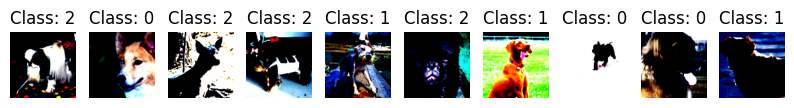

In [69]:
trainDL, validDL, OUT = make_DataLoader(128, 64, True)


In [70]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("DEVICE :", DEVICE)


DEVICE : cpu


In [71]:
MODEL = Custom_VGG(
    features=make_layers(cfgs["VGG6"], batch_norm=True), nclasses=OUT
).to(DEVICE)

OPTIMIZER = optim.Adam(MODEL.parameters())

LOSS_FN = nn.CrossEntropyLoss()


In [72]:
summary(MODEL, input_size=(64, 3, 112, 112))


Layer (type:depth-idx)                   Output Shape              Param #
Custom_VGG                               [64, 3]                   --
├─Sequential: 1-1                        [64, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 64, 112, 112]        1,792
│    └─BatchNorm2d: 2-2                  [64, 64, 112, 112]        128
│    └─ReLU: 2-3                         [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [64, 64, 56, 56]          --
│    └─Conv2d: 2-5                       [64, 128, 56, 56]         73,856
│    └─BatchNorm2d: 2-6                  [64, 128, 56, 56]         256
│    └─ReLU: 2-7                         [64, 128, 56, 56]         --
│    └─MaxPool2d: 2-8                    [64, 128, 28, 28]         --
│    └─Conv2d: 2-9                       [64, 256, 28, 28]         295,168
│    └─BatchNorm2d: 2-10                 [64, 256, 28, 28]         512
│    └─ReLU: 2-11                        [64, 256, 28, 28]         --


In [81]:
def learning(epoch, model, loader, optimizer, scores, mode="train", log_interval=100):
    if mode == "train":
        model.train()
        is_train = True
    elif mode == "test":
        model.eval()
        is_train = False
    else:
        raise ValueError("Invalid mode:", mode)

    loss_value = 0
    correct = 0
    with torch.set_grad_enabled(is_train):
        for batch_idx, (image, label) in enumerate(loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            output = model(image)
            loss = LOSS_FN(output, label)
            loss_value += loss.item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if batch_idx % log_interval == 0:
                    print(
                        f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}"
                    )
                scores.append(loss.item())

            if not is_train:
                scores.append(loss.item())

    loss_value /= len(loader.dataset)
    accuracy = 100.0 * correct / len(loader.dataset)
    return loss_value, accuracy


In [82]:
EPOCHS = 10
train_loss_batch = []
test_loss_batch = []
test_loss_epoch = []
test_acc_epoch = []
save_dir = "../model/"

for epoch in range(1, EPOCHS + 1):

    learning(
        epoch,
        MODEL,
        trainDL,
        OPTIMIZER,
        train_loss_batch,
        mode="train",
        log_interval=10,
    )
    test_loss, test_accuracy = learning(
        epoch, MODEL, validDL, OPTIMIZER, test_loss_batch, mode="test"
    )
    test_loss_epoch.append(test_loss)
    test_acc_epoch.append(test_accuracy)
    print(
        f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n"
    )

    path = save_dir + f"vgg6_{epoch}.pth"
    torch.save(MODEL, path)


Train Epoch: 1 [0]	Train Loss: 1.058630
Train Epoch: 1 [10]	Train Loss: 1.073392
Train Epoch: 1 [20]	Train Loss: 1.070294
Train Epoch: 1 [30]	Train Loss: 1.080031
Train Epoch: 1 [40]	Train Loss: 1.041101
Train Epoch: 1 [50]	Train Loss: 1.056344
Train Epoch: 1 [60]	Train Loss: 1.075887
Train Epoch: 1 [70]	Train Loss: 1.024143
Train Epoch: 1 [80]	Train Loss: 1.123187
Train Epoch: 1 [90]	Train Loss: 1.041397
Train Epoch: 1 [100]	Train Loss: 1.054201
Train Epoch: 1 [110]	Train Loss: 1.070304
Train Epoch: 1 [120]	Train Loss: 1.070153
Train Epoch: 1 [130]	Train Loss: 1.022663
Train Epoch: 1 [140]	Train Loss: 1.017284
Train Epoch: 1 [150]	Train Loss: 1.050058
Train Epoch: 1 [160]	Train Loss: 1.045809
Train Epoch: 1 [170]	Train Loss: 1.038552
Train Epoch: 1 [180]	Train Loss: 1.015596
Train Epoch: 1 [190]	Train Loss: 1.033025
Train Epoch: 1 [200]	Train Loss: 1.094285
Train Epoch: 1 [210]	Train Loss: 1.088494
Train Epoch: 1 [220]	Train Loss: 1.064669
Train Epoch: 1 [230]	Train Loss: 0.974920
Tra

['BIG', 'MID', 'SMALL']
20283
20283
(18254, 1)
(2029, 1)
(18254,)
(2029,)
20283 20283


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([64, 3, 224, 224]) torch.Size([64])


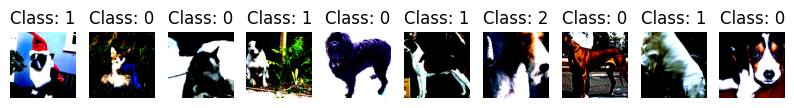

In [55]:
trainDL2, validDL2, OUT2 = make_DataLoader(256, 64, True)


In [56]:
vgg_sequential = nn.Sequential(
    nn.Linear(512 * 7 * 7, 2048),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(2048, out_features=256),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(256, 3),
)


In [57]:
vgg_model = vgg11(weights=VGG11_Weights.DEFAULT)

vgg_model.classifier = vgg_sequential


In [58]:
summary(model=vgg_model, input_size=(64, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 3]                   --
├─Sequential: 1-1                        [64, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [64, 64, 224, 224]        --
│    └─MaxPool2d: 2-3                    [64, 64, 112, 112]        --
│    └─Conv2d: 2-4                       [64, 128, 112, 112]       73,856
│    └─ReLU: 2-5                         [64, 128, 112, 112]       --
│    └─MaxPool2d: 2-6                    [64, 128, 56, 56]         --
│    └─Conv2d: 2-7                       [64, 256, 56, 56]         295,168
│    └─ReLU: 2-8                         [64, 256, 56, 56]         --
│    └─Conv2d: 2-9                       [64, 256, 56, 56]         590,080
│    └─ReLU: 2-10                        [64, 256, 56, 56]         --
│    └─MaxPool2d: 2-11                   [64, 256, 28, 28]         -

In [59]:
for name, param in vgg_model.named_parameters():
    param.requires_grad = False

for name, param in vgg_model.classifier.named_parameters():
    param.requires_grad = True


In [60]:
EPOCHS = 1

for epoch in range(1, EPOCHS + 1):

    learning(epoch, vgg_model, trainDL2, OPTIMIZER, mode="train", log_interval=10)
    test_loss, test_accuracy = learning(
        epoch, vgg_model, validDL2, OPTIMIZER, mode="test"
    )

    print(
        f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n"
    )


Train Epoch: 1 [0]	Train Loss: 1.135526
Train Epoch: 1 [10]	Train Loss: 1.163082
Train Epoch: 1 [20]	Train Loss: 1.109856
Train Epoch: 1 [30]	Train Loss: 1.163166
Train Epoch: 1 [40]	Train Loss: 1.157794


KeyboardInterrupt: 